In [1]:
import numpy as np
import yfinance as yf
import pandas as pd

import gym
import gym_anytrading
import matplotlib.pyplot as plt
import stable_baselines as sb
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
import quantstats as qs
import pyfolio as pf

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."
/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


### Get datas


In [2]:
#time period (for training)
starts = "2010-01-01"
ends = "2019-12-31"

In [3]:
tickers = ["amd", "aapl", "intc"]
tickers_data = {}

In [4]:
folder = [None]*len(tickers)

In [5]:
for idx, t in enumerate(tickers):
    folder[idx] = yf.download(t, starts, ends)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
amd = folder[idx] = yf.download("amd", starts, ends)

[*********************100%***********************]  1 of 1 completed


In [7]:
folder[1].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.413372,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.382690,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.521944,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.828764,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.083660,134247600


### Build Environment

In [8]:
#use first 0.7 for training
portion = 0.7

In [9]:
frame_bound_end_bound = int(np.floor(len(folder[1])*portion))

In [10]:
#frame bound means (>= window_size, ) specifies start/end of df
#window_size means how many past references agent has available to learn from
env = gym.make('stocks-v0', df=amd, frame_bound=(5,frame_bound_end_bound), window_size=5)

info {'total_reward': 2.849994659423828, 'total_profit': 0.15704043390271996, 'position': 0}


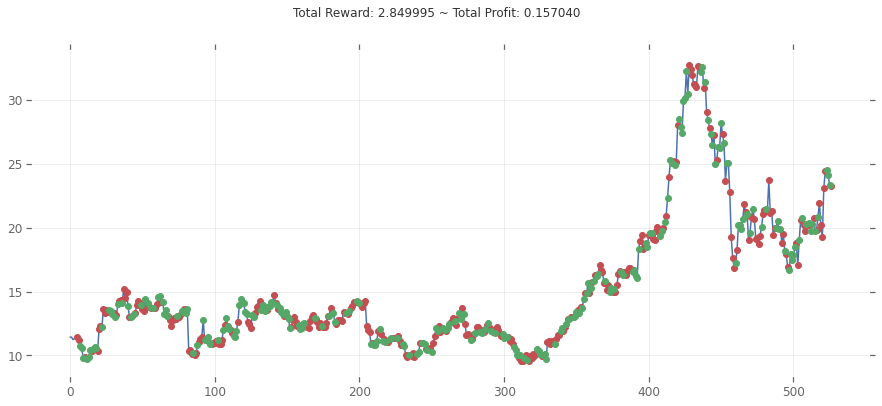

In [11]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

## Example from
https://github.com/AminHP/gym-anytrading/blob/master/examples/a2c_quantstats.ipynb

### Build Env & Training with stable baselines

In [12]:
window_size = 5
start_index = window_size
end_index = frame_bound_end_bound

In [13]:
env_maker = lambda: gym.make('stocks-v0', df=amd, frame_bound=(start_index, end_index), window_size=window_size)
env = DummyVecEnv([env_maker])

### Train Environment

In [14]:
model = A2C('MlpLstmPolicy', env, verbose=0) #optionally use policy_kwargs
model.learn(total_timesteps=1000)






Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [15]:
#save model
model.save("a2cMlp")

### Test Environment

In [16]:
d = {"hi": 8, "boo":99}

In [17]:
for thing in d:
    print(thing)
    print(d[thing])

hi
8
boo
99


In [18]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]
    
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)
    
    if done:
        print("info:", info)
        break

info: {'total_reward': 7.570006370544434, 'total_profit': 0.208053254289488, 'position': 1}


### Plot Results

In [19]:
type(env)

gym_anytrading.envs.stocks_env.StocksEnv

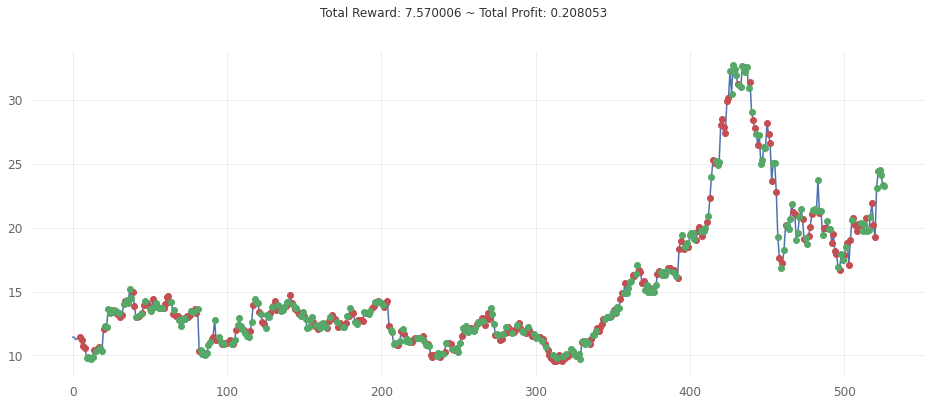

In [20]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Analysis Using quantstats

                           Strategy
-------------------------  ----------
Start Period               2017-01-12
End Period                 2019-02-06
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -79.19%
CAGR%                      -53.19%

Sharpe                     -1.6
Sortino                    -1.94
Sortino/√2                 -1.38

Max Drawdown               -84.84%
Longest DD Days            722
Volatility (ann.)          41.7%
Calmar                     -0.63
Skew                       -2.18
Kurtosis                   24.26

Expected Daily %           -0.3%
Expected Monthly %         -5.86%
Expected Yearly %          -40.75%
Kelly Criterion            -26.28%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.59%
Expected Shortfall (cVaR)  -4.59%

Gain/Pain Ratio            -0.44
Gain/Pain (1M)             -0.63

Payoff Ratio               1.13
Profit Factor              0.56
Common Sense Ratio         0.27
CPC Index     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-02-14,2019-01-08,2019-02-06,722,-84.843783,-84.819998
2,2017-01-19,2017-01-19,2017-01-24,5,-1.996545,0.000000


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


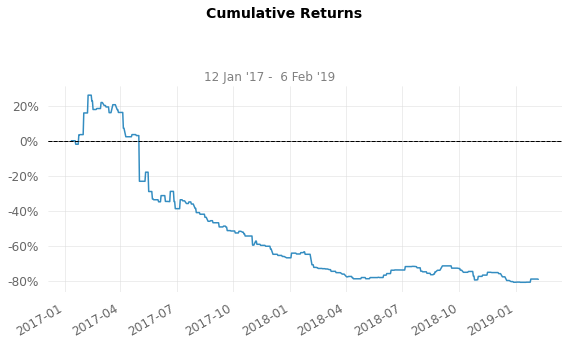

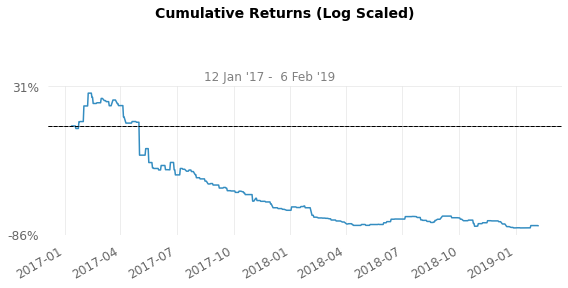

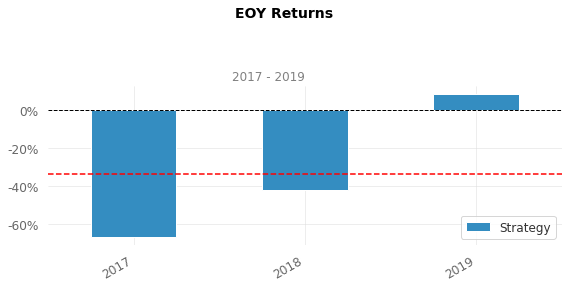

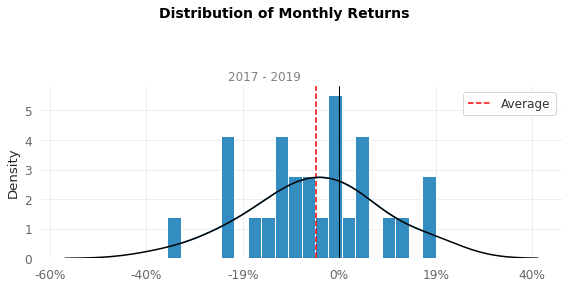

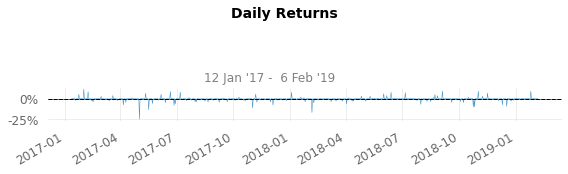

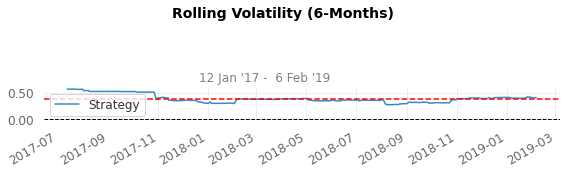

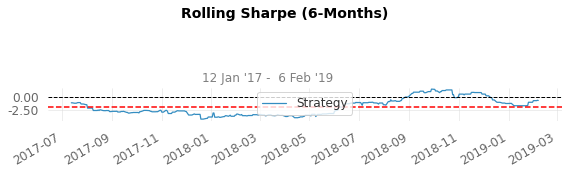

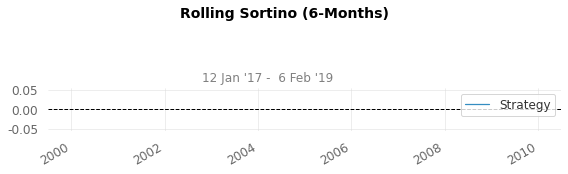

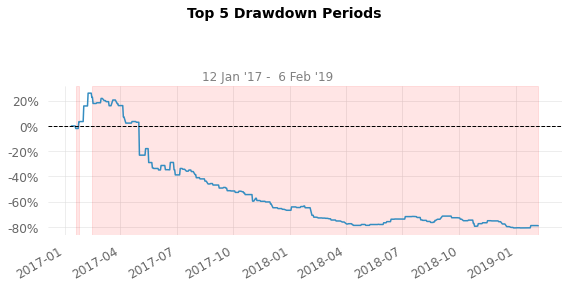

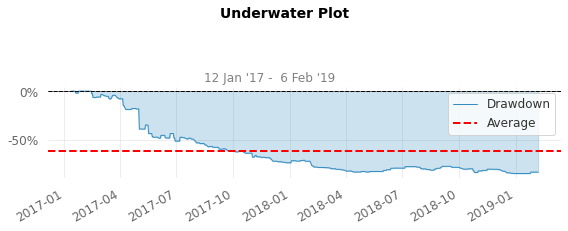

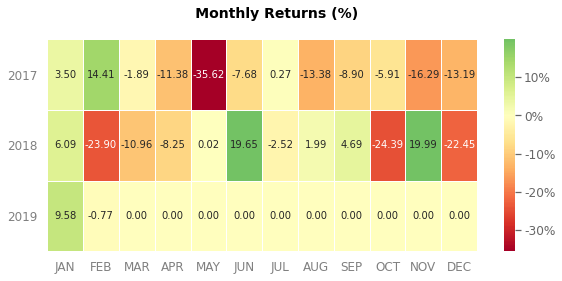

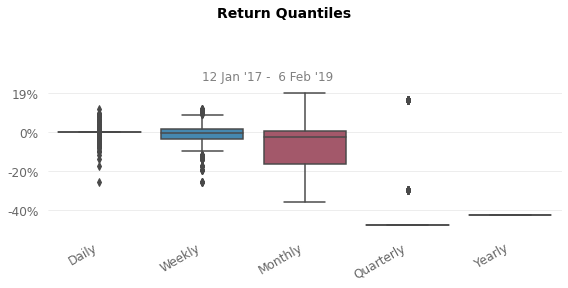

In [21]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=amd.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')

In [24]:
type(qs.reports.metrics(returns))

                    Strategy
------------------  ----------
Start Period        2017-01-12
End Period          2019-02-06
Risk-Free Rate      0.0%
Time in Market      25.0%

Cumulative Return   -79.19%
CAGR%               -53.19%

Sharpe              -1.6
Sortino             -1.94
Sortino/√2          -1.38

Max Drawdown        -84.84%
Longest DD Days     722

Gain/Pain Ratio     -0.44
Gain/Pain (1M)      -0.63

Payoff Ratio        1.13
Profit Factor       0.56
Common Sense Ratio  0.27
CPC Index           0.21
Tail Ratio          0.49
Outlier Win Ratio   21.67
Outlier Loss Ratio  2.74

MTD                 -0.77%
3M                  -7.5%
6M                  -17.12%
YTD                 8.73%
1Y                  -28.58%
3Y (ann.)           -53.19%
5Y (ann.)           -53.19%
10Y (ann.)          -53.19%
All-time (ann.)     -53.19%

Avg. Drawdown       -43.42%
Avg. Drawdown Days  364
Recovery Factor     -0.93
Ulcer Index         inf


NoneType

In [ ]:
qs.plots.snapshot(returns)

In [ ]:
returns

In [ ]:
#evaluate model
env = gym.make('stocks-v0', df=amd, frame_bound=(571,700), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()